In [14]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Flatten, Conv1D, Dropout, MaxPooling1D, Activation, GlobalMaxPooling1D, Input, Conv2D, Reshape, LSTM, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam, SGD

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow.random as random

seed = 111
random.set_seed(seed)
np.random.seed(seed)

In [2]:
df = pd.read_csv("cleaned_data/cleaned_reviews_3.csv")
df["text"] = df["text"].apply(lambda x: ast.literal_eval(x))
df["detoken"] = df["text"].apply(lambda y: TreebankWordDetokenizer().tokenize(y))
df.head()

,review,text,rating,sentiment,detoken
0,"This started out strong, but it went downhill ...","[start, out, strong, but, go, downhill, fairly...",1,0,start out strong but go downhill fairly quickl...
1,"A decently written YA book, but I can't even c...","[decently, write, ya, book, but, can, even, co...",1,0,decently write ya book but can even consider e...
2,"Ugh...I tried, I honestly tried. I'm a huge fa...","[ugh, try, honestly, try, huge, fan, scott, we...",1,0,ugh try honestly try huge fan scott westerfeld...
3,Main points: \n 1. Never ever introduce a poin...,"[main, point, never, ever, introduce, point, v...",1,0,main point never ever introduce point view sid...
4,Why do all YA books have to have a love triang...,"[all, ya, book, love, triangle, now, just, who...",1,0,all ya book love triangle now just whole world...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     11400 non-null  object
 1   text       11400 non-null  object
 2   rating     11400 non-null  int64 
 3   sentiment  11400 non-null  int64 
 4   detoken    11400 non-null  object
dtypes: int64(2), object(3)
memory usage: 445.4+ KB


In [3]:
df_pos, df_neg = split_sentiment(df)
df_train, df_test = split_train_test(df_pos, df_neg, 222)

train_words = [word for text in df_train["text"] for word in text]
train_text_length = [len(text) for text in df_train["text"]]

vocab = list(set(train_words))
vocab_size = len(vocab)

print(f"There are {len(train_words)} train words in total and the vocabulary size is {vocab_size}.")

There are 515575 train words in total and the vocabulary size is 18590.


In [4]:
train_data = df_train["detoken"].tolist()
test_data = df_test["detoken"].tolist()

tokenizer = Tokenizer(num_words=15000)
tokenizer.fit_on_texts(train_data)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

# max_length = max(max([len(x) for x in train_sequences]), max([len(x) for x in test_sequences]))
max_length = 150

x_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post")
x_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post")

ytrain, ytest = np.asarray(df_train["sentiment"]), np.asarray(df_test["sentiment"])

print(max_length)
print(x_train_padded.shape)
print(x_test_padded.shape)
print(ytrain.shape)
print(ytest.shape)
print(f"Found {len(word_index)} unique tokens")

150
(9120, 150)
(2280, 150)
(9120,)
(2280,)
Found 18616 unique tokens


In [5]:
embeddings_dict = {}
with open("glove.42B.300d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [6]:
vocab_train = vocab_build(df_train["text"])
vocab_test = vocab_build(df_test["text"])

train_covered, train_oov, train_vocab_coverage, train_text_coverage = embedding_coverage(df_train["text"], embeddings_dict)
test_covered, test_oov, test_vocab_coverage, test_text_coverage = embedding_coverage(df_test["text"], embeddings_dict)

print(f"Glove embeddings cover {round(train_vocab_coverage, 2)}% of vocabulary and {round(train_text_coverage, 2)}% text in training set")
print(f"Glove embeddings cover {round(test_vocab_coverage, 2)}% of vocabulary and {round(test_text_coverage, 2)}% text in testing set")

Glove embeddings cover 95.22% of vocabulary and 99.79% text in training set
Glove embeddings cover 97.13% of vocabulary and 99.76% text in testing set


In [7]:
EMBEDDING_DIM = 300
MAX_WORDS = 15000
vocab_size = min(len(word_index) + 1, MAX_WORDS)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    
    try:
        embedding_vector = embeddings_dict[word]
        embedding_matrix[i] = embedding_vector
    
    except KeyError:
        embedding_vector = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length, trainable=False)

del(embedding_matrix)

#### CNN + LSTM

In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation="relu"))
# model.add(GlobalMaxPooling1D())
model.add(MaxPooling1D(4))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          4500000   
                                                                 
 conv1d_6 (Conv1D)           (None, 146, 128)          192128    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 36, 128)          0         
 1D)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                      

In [30]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.01

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/5
114/114 [==============================] - 9s 67ms/step - loss: 0.6659 - accuracy: 0.6250 - val_loss: 1.1071 - val_accuracy: 0.0000e+00
Epoch 2/5
114/114 [==============================] - 8s 67ms/step - loss: 0.6637 - accuracy: 0.6250 - val_loss: 1.0089 - val_accuracy: 0.0000e+00
Epoch 3/5
114/114 [==============================] - 8s 69ms/step - loss: 0.6622 - accuracy: 0.6250 - val_loss: 0.9429 - val_accuracy: 0.0000e+00
Epoch 4/5
114/114 [==============================] - 8s 73ms/step - loss: 0.6623 - accuracy: 0.6250 - val_loss: 0.8945 - val_accuracy: 0.0000e+00
Epoch 5/5
114/114 [==============================] - 8s 72ms/step - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.9678 - val_accuracy: 0.0000e+00


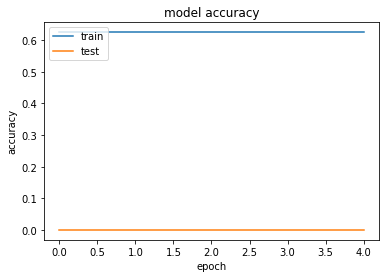

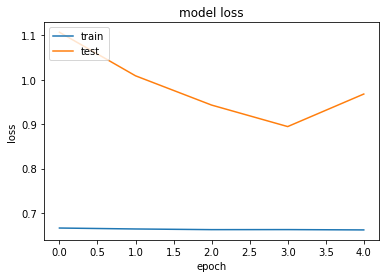

72/72 - 1s - loss: 0.7221 - accuracy: 0.5000 - 856ms/epoch - 12ms/step
Test accuracy: 0.5


In [31]:
# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

#### CNN + GRU

In [71]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation="relu"))
# model.add(GlobalMaxPooling1D())
model.add(MaxPooling1D(4))
model.add(GRU(32))
model.add(Dropout(0.2))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          4500000   
                                                                 
 conv1d_26 (Conv1D)          (None, 146, 128)          192128    
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 36, 128)          0         
 g1D)                                                            
                                                                 
 gru_11 (GRU)                (None, 32)                15552     
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_36 (Dense)            (None, 16)                528       
                                                     

In [72]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.01

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/5
114/114 [==============================] - 8s 63ms/step - loss: 0.6663 - accuracy: 0.6229 - val_loss: 1.0774 - val_accuracy: 5.4825e-04
Epoch 2/5
114/114 [==============================] - 7s 64ms/step - loss: 0.6606 - accuracy: 0.6255 - val_loss: 0.8880 - val_accuracy: 0.1793
Epoch 3/5
114/114 [==============================] - 8s 66ms/step - loss: 0.6401 - accuracy: 0.6353 - val_loss: 0.9175 - val_accuracy: 0.5274
Epoch 4/5
114/114 [==============================] - 10s 86ms/step - loss: 0.6217 - accuracy: 0.6380 - val_loss: 0.8449 - val_accuracy: 0.5351
Epoch 5/5
114/114 [==============================] - 10s 89ms/step - loss: 0.6027 - accuracy: 0.6769 - val_loss: 0.8585 - val_accuracy: 0.5378


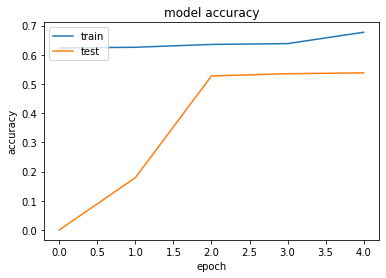

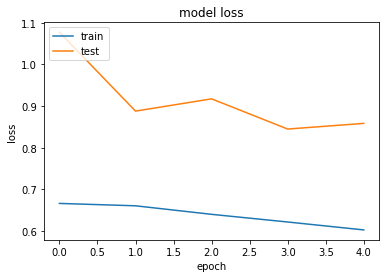

72/72 - 1s - loss: 0.6572 - accuracy: 0.6526 - 922ms/epoch - 13ms/step
Test accuracy: 0.6526315808296204


In [73]:
# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

#### LSTM + CNN

In [74]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Conv1D(64, 4, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

ValueError: Input 0 of layer "conv1d_27" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 128)

In [ ]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/5
114/114 [==============================] - 9s 64ms/step - loss: 0.5798 - accuracy: 0.6887 - val_loss: 0.8592 - val_accuracy: 0.6442
Epoch 2/5
114/114 [==============================] - 7s 62ms/step - loss: 0.3785 - accuracy: 0.8355 - val_loss: 0.3832 - val_accuracy: 0.8816
Epoch 3/5
114/114 [==============================] - 7s 64ms/step - loss: 0.3005 - accuracy: 0.8729 - val_loss: 0.5196 - val_accuracy: 0.7714
Epoch 4/5
114/114 [==============================] - 7s 65ms/step - loss: 0.2098 - accuracy: 0.9227 - val_loss: 0.5620 - val_accuracy: 0.7434
Epoch 5/5
114/114 [==============================] - 8s 67ms/step - loss: 0.1347 - accuracy: 0.9515 - val_loss: 0.4019 - val_accuracy: 0.8542


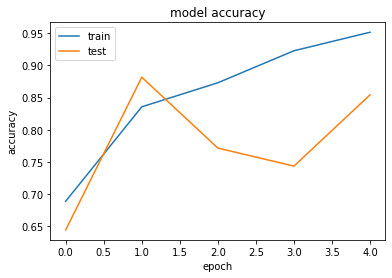

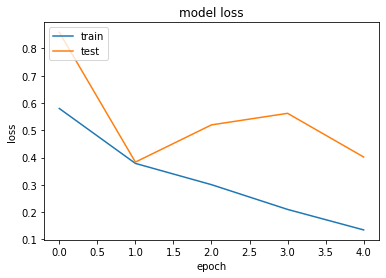

72/72 - 1s - loss: 0.3998 - accuracy: 0.8632 - 867ms/epoch - 12ms/step
Test accuracy: 0.8631578683853149


In [ ]:
# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")